In [21]:
'''pip install nbimporter
'''

'pip install nbimporter\n'

In [22]:
import nbimporter

#==============================Dependencies================================

#libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, truncnorm
from numpy.random import Generator, MT19937
import time

#Initializing the random number generator
seed = int(time.time()) 
bitgen = MT19937(seed)
rng = Generator(bitgen)  # reproducible generator

In [23]:
from hybrid_mcmc_KDE import metropolis_python, silverman_bandwidth, adaptive_kde, hybrid_importance_sampling  

from Importance_Int import importance_integration, target_pdf

from Uniform_MC import uniform_mc_integrate

In [24]:
def integration_over_N(integration_type, N_values, f, rng, **kwargs):
    """
    Compute integration estimates, variances, and standard errors for a range of N values.
    
    Parameters:
        integration_type (str): The type of integration to perform. 
            Options are "uniform", "importance", or "hybrid".
        N_values (array-like): An array of sample sizes to iterate over.
        f (callable): The integrand function.
        rng (np.random.Generator): Random number generator.
        kwargs: Additional keyword arguments required by a given integration method.
            For the "uniform" method, provide:
                a (float): lower integration limit
                b (float): upper integration limit
            For the "hybrid" method, you may provide:
                initial_point (float): starting point for the metropolis chain (default: rng.uniform(-1,1))
                proposal_width (float): proposal step width (default: 4)
                burn_in (int): number of burn-in iterations (default: 200)
                thinning (int): thinning factor (default: 1)
                kde_alpha (float): alpha parameter for adaptive_kde (default: 0.5)
    
    Returns:
        estimates (np.ndarray): Array of integration estimates for each N.
        variances (np.ndarray): Array of variances for each N.
        standard_errors (np.ndarray): Array of standard errors for each N.
    """
    estimates = []
    variances = []
    standard_errors = []

    for N in N_values:
        if integration_type == "uniform":
            a = kwargs.get('a')
            b = kwargs.get('b')
            if a is None or b is None:
                raise ValueError("For uniform integration, 'a' and 'b' must be provided.")
            estimate, var, se = uniform_mc_integrate(f, a, b, N, rng)
            
        elif integration_type == "importance":
            estimate, var, se = importance_integration(f, N, rng)
            
        elif integration_type == "hybrid":
            # Optional parameters for hybrid method
            initial_point = kwargs.get('initial_point', rng.uniform(-1, 1))
            proposal_width = kwargs.get('proposal_width', 4)
            burn_in = kwargs.get('burn_in', 200)
            thinning = kwargs.get('thinning', 1)
            kde_alpha = kwargs.get('kde_alpha', 0.5)
            
            m_chain = metropolis_python(f, N, initial_point, proposal_width, burn_in, thinning)
            h_fixed = silverman_bandwidth(m_chain)
            kde = adaptive_kde(m_chain, h_fixed, alpha=kde_alpha)
            estimate, var, se = hybrid_importance_sampling(f, m_chain, kde)
            
        else:
            raise ValueError(f"Unknown integration type: {integration_type}")
        
        estimates.append(estimate)
        variances.append(var)
        standard_errors.append(se)
        
    return np.array(estimates), np.array(variances), np.array(standard_errors)

In [25]:
# Define a range of N values
N_values = np.logspace(1, 4, num=50, dtype=int)  # N ranges from 10 to 10,000
def f(x):
    return np.exp(-x**2)
a=-10

b=10

xo= rng.uniform(-2, 2)  # Initial point for the hybrid method
stepsize = 2 # Proposal step width for the hybrid method
burn_in = 200 # Number of burn-in iterations for the hybrid method
thinning = 1   # Thinning factor for the hybrid method
kde_alpha = 0.5 # Alpha parameter for adaptive KDE in the hybrid method

estimates_u, variances_u, standard_errors_u = integration_over_N('uniform', N_values, f, rng, a=a, b=b)

estimates_i, variances_i, standard_errors_i = integration_over_N('importance', N_values, f, rng)

estimates_h, variances_h, standard_errors_h = integration_over_N('hybrid', N_values, f, rng,
    initial_point=xo,
    proposal_width=stepsize,
    burn_in=burn_in,
    thinning=thinning,
    kde_alpha=kde_alpha
)

Acceptance rate: 0.44
Acceptance rate: 0.38
Acceptance rate: 0.38
Acceptance rate: 0.44
Acceptance rate: 0.36
Acceptance rate: 0.36
Acceptance rate: 0.40
Acceptance rate: 0.44
Acceptance rate: 0.43
Acceptance rate: 0.37
Acceptance rate: 0.43
Acceptance rate: 0.34
Acceptance rate: 0.38
Acceptance rate: 0.39
Acceptance rate: 0.38
Acceptance rate: 0.33
Acceptance rate: 0.43
Acceptance rate: 0.37
Acceptance rate: 0.40
Acceptance rate: 0.39
Acceptance rate: 0.38
Acceptance rate: 0.37
Acceptance rate: 0.40
Acceptance rate: 0.39
Acceptance rate: 0.38
Acceptance rate: 0.40
Acceptance rate: 0.41
Acceptance rate: 0.39
Acceptance rate: 0.38
Acceptance rate: 0.41
Acceptance rate: 0.39
Acceptance rate: 0.40
Acceptance rate: 0.37
Acceptance rate: 0.36
Acceptance rate: 0.38
Acceptance rate: 0.38
Acceptance rate: 0.40
Acceptance rate: 0.38
Acceptance rate: 0.41
Acceptance rate: 0.37
Acceptance rate: 0.38
Acceptance rate: 0.40
Acceptance rate: 0.38
Acceptance rate: 0.39
Acceptance rate: 0.38
Acceptance

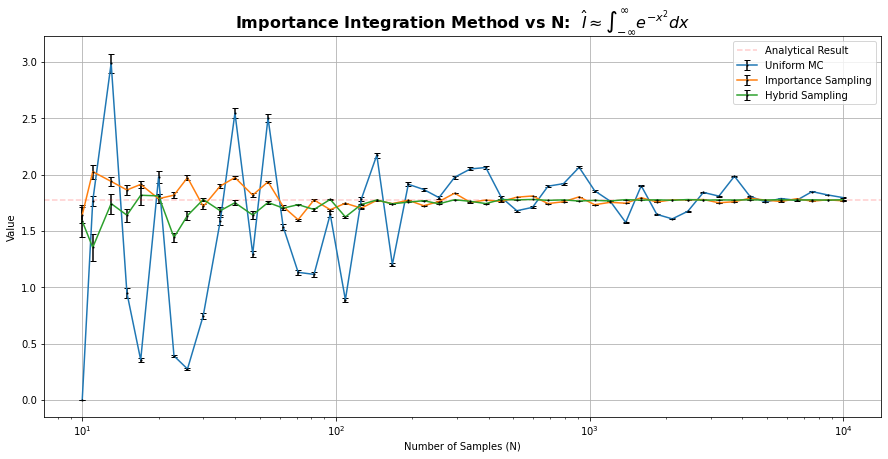

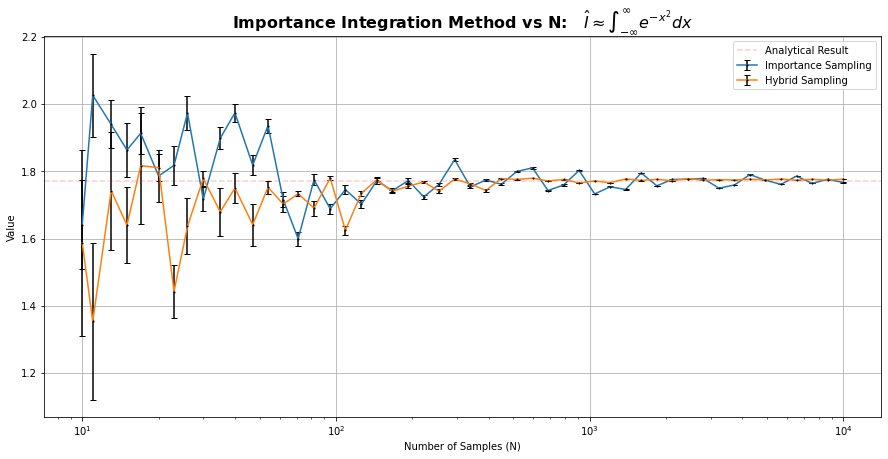

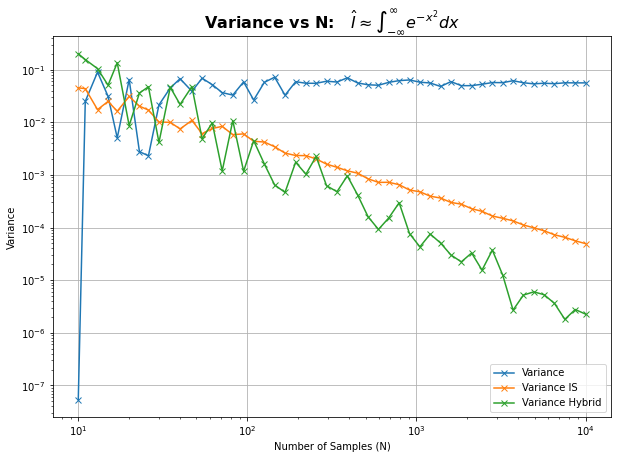

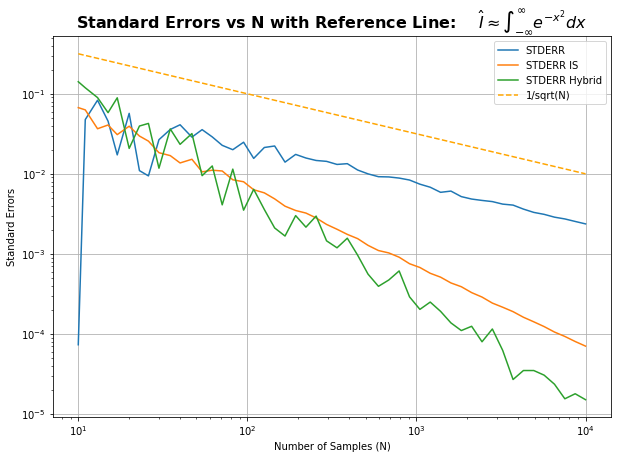

In [29]:

def plot_integration_results(N_values, estimates_u, standard_errors_u, estimates_i, standard_errors_i, 
                              estimates_h, standard_errors_h, variances_u, variances_i, variances_h, 
                              reference_line, analytical_result, function_description):
    """
    Plot integration results including estimates, variances, and standard errors.

    Parameters:
        N_values (numpy.ndarray): Array of sample sizes.
        estimates_u (numpy.ndarray): Uniform MC estimates.
        standard_errors_u (numpy.ndarray): Standard errors for Uniform MC.
        estimates_i (numpy.ndarray): Importance Sampling estimates.
        standard_errors_i (numpy.ndarray): Standard errors for Importance Sampling.
        estimates_h (numpy.ndarray): Hybrid Sampling estimates.
        standard_errors_h (numpy.ndarray): Standard errors for Hybrid Sampling.
        variances_u (numpy.ndarray): Variances for Uniform MC.
        variances_i (numpy.ndarray): Variances for Importance Sampling.
        variances_h (numpy.ndarray): Variances for Hybrid Sampling.
        reference_line (numpy.ndarray): Reference line values (1/sqrt(N)).
        analytical_result (float): Analytical result of the integral.
        function_description (str): Description of the function being integrated.
    """
    plt.rcParams.update({'axes.titlesize': 16, 'axes.titleweight': 'bold', 'axes.titlepad': -20})

    # Plot estimates with error bars
    plt.figure(figsize=(15, 7))
    plt.errorbar(N_values, estimates_u, yerr=standard_errors_u, label='Uniform MC', 
                 fmt='s-', markersize=1, markerfacecolor='black', markeredgecolor='black', 
                 ecolor='black', capsize=3)
    plt.errorbar(N_values, estimates_i, yerr=standard_errors_i, label='Importance Sampling', 
                 fmt='s-', markersize=1, markerfacecolor='black', markeredgecolor='black', 
                 ecolor='black', capsize=3)
    plt.errorbar(N_values, estimates_h, yerr=standard_errors_h, label='Hybrid Sampling', 
                 fmt='s-', markersize=1, markerfacecolor='black', markeredgecolor='black', 
                 ecolor='black', capsize=3)

    plt.axhline(y=analytical_result, color='red', linestyle='--', label='Analytical Result', alpha=0.2)
    plt.xscale('log')
    plt.xlabel('Number of Samples (N)')
    plt.ylabel('Value')
    plt.title(f'Importance Integration Method vs N:  {function_description}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot estimates with 95% confidence intervals
    plt.figure(figsize=(15, 7))
    plt.errorbar(N_values, estimates_i, yerr=1.96 * standard_errors_i, label='Importance Sampling', 
                 fmt='s-', markersize=1, markerfacecolor='black', markeredgecolor='black', 
                 ecolor='black', capsize=3)
    plt.errorbar(N_values, estimates_h, yerr=1.96 * standard_errors_h, label='Hybrid Sampling', 
                 fmt='s-', markersize=1, markerfacecolor='black', markeredgecolor='black', 
                 ecolor='black', capsize=3)

    plt.axhline(y=analytical_result, color='red', linestyle='--', label='Analytical Result', alpha=0.2)
    plt.xscale('log')
    plt.xlabel('Number of Samples (N)')
    plt.ylabel('Value')
    plt.title(f'Importance Integration Method vs N:   {function_description}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot variances
    plt.figure(figsize=(10, 7))
    plt.plot(N_values, variances_u, label='Variance', marker='x')
    plt.plot(N_values, variances_i, label='Variance IS', marker='x')
    plt.plot(N_values, variances_h, label='Variance Hybrid', marker='x')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of Samples (N)')
    plt.ylabel('Variance')
    plt.title(f'Variance vs N:   {function_description}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot standard errors
    plt.figure(figsize=(10, 7))
    plt.plot(N_values, standard_errors_u, label='STDERR')
    plt.plot(N_values, standard_errors_i, label='STDERR IS')
    plt.plot(N_values, standard_errors_h, label='STDERR Hybrid')
    plt.plot(N_values, reference_line, label='1/sqrt(N)', linestyle='--', color='orange')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of Samples (N)')
    plt.ylabel('Standard Errors')
    plt.title(f'Standard Errors vs N with Reference Line:    {function_description}')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_integration_results(
    N_values, estimates_u, standard_errors_u, estimates_i, standard_errors_i, 
    estimates_h, standard_errors_h, variances_u, variances_i, variances_h, 
    reference_line, analytical_result, function_description
)
